<a href="https://colab.research.google.com/github/GUNTERMAXIMUS/covid-19predictCL/blob/master/covod_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  %tensorflow_version 2.x
except OSError:
  print(tf.__version__)
finally:
  import tensorflow as tf
  from tensorflow.keras import Sequential
  from tensorflow.keras.layers import Dense, LSTM, Dropout
  from sklearn.preprocessing import MinMaxScaler
  scaler = MinMaxScaler()
  
  import numpy as np
  import pandas as pd
  import matplotlib.pyplot as plt
  
  import requests as rq
  import io
  
  print(f'TF version: {tf.__version__}')
  
#  from google.colab import drive
#  drive.mount('/content/gdrive', force_remount = True, timeout_ms = 60000)


TF version: 2.2.0-rc2


In [0]:
url = 'https://raw.githubusercontent.com/GUNTERMAXIMUS/covid-19predictCL/master/covid_19_data.csv'

respond = rq.get(url).content

df_data = pd.read_csv(io.StringIO(respond.decode('utf-8')), 
                      sep = ',', 
                      quotechar = '"', 
                      usecols = [1, 3, 5, 6 , 7], 
                      encoding = 'utf-8')

df_train = pd.read_csv(io.StringIO(respond.decode('utf-8')), 
                      sep = ',', 
                      quotechar = '"', 
                      usecols = [1, 3, 5, 6 , 7], 
                      encoding = 'utf-8')

In [3]:
df = df_data[df_data['Country/Region'].str.contains('Chile')].dropna()
df_train.dropna()
print(df.isnull().any())
df.tail(10)

ObservationDate    False
Country/Region     False
Confirmed          False
Deaths             False
Recovered          False
dtype: bool


,ObservationDate,Country/Region,Confirmed,Deaths,Recovered
7945,03/23/2020,Chile,746.0,2.0,11.0
8240,03/24/2020,Chile,922.0,2.0,17.0
8539,03/25/2020,Chile,1142.0,3.0,22.0
8841,03/26/2020,Chile,1306.0,4.0,22.0
9148,03/27/2020,Chile,1610.0,5.0,43.0
9455,03/28/2020,Chile,1909.0,6.0,61.0
9766,03/29/2020,Chile,2139.0,7.0,75.0
10078,03/30/2020,Chile,2449.0,8.0,156.0
10391,03/31/2020,Chile,2738.0,12.0,156.0
10704,04/01/2020,Chile,3031.0,16.0,234.0


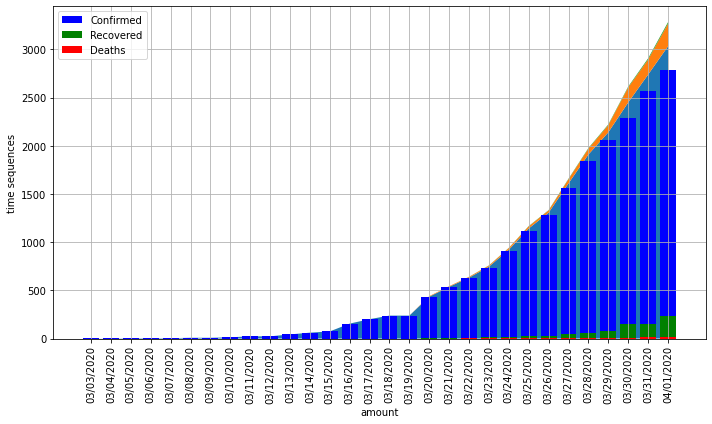

In [4]:
x = df.ObservationDate
y = (df.Confirmed) - (df.Recovered + df.Deaths)

plt.figure(figsize = (10, 6))
plt.bar(x, y, label = 'Confirmed', color = 'blue')
plt.bar(x, df.Recovered, label = 'Recovered', color = 'green')
plt.bar(x, df.Deaths, label = 'Deaths', color = 'red')
plt.stackplot(x, df.Confirmed, df.Recovered, df.Deaths)
plt.xlabel('amount')
plt.ylabel('time sequences')
plt.legend(loc = 'upper left')
plt.xticks(rotation = 'vertical')
plt.tight_layout()
plt.grid(True)

plt.show()

In [10]:
train_data = (df_train.drop(columns=['ObservationDate', 'Country/Region'], axis = 1)) #.values
train_data = (scaler.fit_transform(train_data))

train_data

array([[9.04371733e-06, 0.00000000e+00, 0.00000000e+00],
       [1.26612043e-04, 0.00000000e+00, 0.00000000e+00],
       [5.42623040e-05, 0.00000000e+00, 0.00000000e+00],
       ...,
       [4.52185866e-05, 0.00000000e+00, 0.00000000e+00],
       [1.64595655e-03, 1.52033447e-04, 2.71610397e-03],
       [1.13679527e-02, 7.60167237e-05, 1.93601364e-02]])

In [16]:
days = 10
x_train, y_train = [], []

for i in range(days, train_data.shape[0]):
  x_train.append(train_data[i - days: i])
  y_train.append(train_data[i, 0]) # opening

x_train = np.array(x_train), np.array(y_train)


array([[[9.04371733e-06, 0.00000000e+00, 0.00000000e+00],
        [1.26612043e-04, 0.00000000e+00, 0.00000000e+00],
        [5.42623040e-05, 0.00000000e+00, 0.00000000e+00],
        ...,
        [9.04371733e-06, 0.00000000e+00, 0.00000000e+00],
        [3.61748693e-05, 0.00000000e+00, 0.00000000e+00],
        [9.04371733e-06, 0.00000000e+00, 0.00000000e+00]],

       [[1.26612043e-04, 0.00000000e+00, 0.00000000e+00],
        [5.42623040e-05, 0.00000000e+00, 0.00000000e+00],
        [9.04371733e-06, 0.00000000e+00, 0.00000000e+00],
        ...,
        [3.61748693e-05, 0.00000000e+00, 0.00000000e+00],
        [9.04371733e-06, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[5.42623040e-05, 0.00000000e+00, 0.00000000e+00],
        [9.04371733e-06, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [9.04371733e-06, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00

In [7]:
model = Sequential()

model.add(tf.keras.layers.LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (x_train.shape[1], 3)))
model.add(Dropout(rate = 0.2))

model.add(tf.keras.layers.LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(rate = 0.2))

model.add(tf.keras.layers.LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(rate = 0.2))

model.add(tf.keras.layers.LSTM(units = 120, activation = 'relu'))
model.add(Dropout(rate = 0.2))

model.add(Dense(units = 1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 60)            15360     
_________________________________________________________________
dropout (Dropout)            (None, 10, 60)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 60)            29040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 60)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 80)            45120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 80)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               9

In [11]:
modelFit = model.fit(x_train, y_train, epochs = 12, batch_size = 32)

Epoch 1/12
343/343 [==============================] - 27s 78ms/step - loss: 0.0035
Epoch 2/12
343/343 [==============================] - 23s 68ms/step - loss: 0.0034
Epoch 3/12
343/343 [==============================] - 23s 68ms/step - loss: 0.0034
Epoch 4/12
343/343 [==============================] - 23s 66ms/step - loss: 0.0034
Epoch 5/12
343/343 [==============================] - 23s 68ms/step - loss: 0.0034
Epoch 6/12
343/343 [==============================] - 23s 67ms/step - loss: 0.0034
Epoch 7/12
343/343 [==============================] - 23s 68ms/step - loss: 0.0034
Epoch 8/12
343/343 [==============================] - 24s 69ms/step - loss: 0.0033
Epoch 9/12
343/343 [==============================] - 23s 67ms/step - loss: 0.0033
Epoch 10/12
343/343 [==============================] - 23s 67ms/step - loss: 0.0032
Epoch 11/12
343/343 [==============================] - 23s 67ms/step - loss: 0.0032
Epoch 12/12
343/343 [==============================] - 23s 67ms/step - loss: 0.0034


In [12]:
test_data = df.drop(columns = ['ObservationDate', 'Country/Region'], axis = 1)
print(test_data)

test_data = scaler.transform(test_data)

x_test, y_test = [], []
for i in range(10, test_data.shape[0]):
  x_test.append(test_data[i-10:i])
  y_test.append(test_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)


       Confirmed  Deaths  Recovered
3198         1.0     0.0        0.0
3357         1.0     0.0        0.0
3487         4.0     0.0        0.0
3670         4.0     0.0        0.0
3875         4.0     0.0        0.0
4093         8.0     0.0        0.0
4351         8.0     0.0        0.0
4612        13.0     0.0        0.0
4804        23.0     0.0        0.0
5028        23.0     0.0        0.0
5282        43.0     0.0        0.0
5469        61.0     0.0        0.0
5721        74.0     0.0        0.0
5950       155.0     0.0        0.0
6219       201.0     0.0        0.0
6496       238.0     0.0        0.0
6792       238.0     0.0        0.0
7062       434.0     0.0        6.0
7358       537.0     0.0        6.0
7646       632.0     1.0        8.0
7945       746.0     2.0       11.0
8240       922.0     2.0       17.0
8539      1142.0     3.0       22.0
8841      1306.0     4.0       22.0
9148      1610.0     5.0       43.0
9455      1909.0     6.0       61.0
9766      2139.0     7.0    

In [0]:
predict = model.predict(x_test)
scale = 1 / float(scaler.scale_[0])
predict = predict * scale

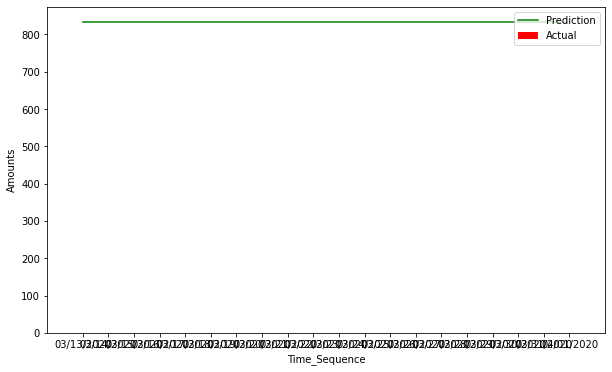

In [14]:
plt.figure(figsize = (10, 6))
plt.bar(x[10:], y_test, label = 'Actual', color = 'red')
plt.plot(x[10:], predict, label = 'Prediction', color = 'green')
plt.xlabel('Time_Sequence')
plt.ylabel('Amounts')
plt.legend(loc = 'upper right')
plt.show()